In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torchvision import datasets, transforms
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [2]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30,is_linear = False):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.is_linear = is_linear
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        if self.is_linear:
          return (self.omega_0 * self.linear(input))
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
device = "cuda"

In [4]:
def hyper_weight_init(m):
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, a=10.0, nonlinearity='relu', mode='fan_in')
        m.weight.data = m.weight.data / 1.e2

    if hasattr(m, 'bias'):
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight)
        with torch.no_grad():
            m.bias.uniform_(-1/fan_in, 1/fan_in)

In [5]:
class Hypernetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 256, kernel_size=3)
        self.fc1 = nn.Linear(173056,256) # hypernetwork decoder
        hyper_weight_init(self.fc1)
        self.fc2 = nn.Linear(256,198401) # hypernetwork decoder
        hyper_weight_init(self.fc2)
    def forward(self, x):
        x = self.conv1(x)

        x = x.view(x.size(0), -1) # encoder part # Flatten the tensor # till this is the encoder part if input.shape = (1,1,28,28) output shape = (1,173056) f input.shape = (10,1,28,28) ouput shape = (1,173056)
        x = self.fc1(x) # decoder relu hypernetwork
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [6]:
siren_model = Siren(in_features=2, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True).to(device)
number_of_parameters = sum(p.numel() for p in siren_model.parameters())
new_dict = siren_model.state_dict().copy()

In [7]:
def siren_network (x,new_dict):
  W0 = new_dict['net.0.linear.weight'].to(device)
  b0 = new_dict['net.0.linear.bias'].to(device)
  W1 = new_dict['net.1.linear.weight'].to(device)
  b1 = new_dict['net.1.linear.bias'].to(device)
  W2 = new_dict['net.2.linear.weight'].to(device)
  b2 = new_dict['net.2.linear.bias'].to(device)
  W3 = new_dict['net.3.linear.weight'].to(device)
  b3 = new_dict['net.3.linear.bias'].to(device)
  W4 = new_dict['net.4.weight'].to(device)
  b4 = new_dict['net.4.bias'].to(device)

  x = F.linear(x,W0,b0)
  x = torch.sin(30*x)
  x = F.linear(x,W1,b1)
  x = torch.sin(30*x)
  x = F.linear(x,W2,b2)
  x = torch.sin(30*x)
  x = F.linear(x,W3,b3)
  x = torch.sin(30*x)
  x = F.linear(x,W4,b4)
  return x

In [8]:
def coordinates (n):
  # Create an empty list to store the tuples
  tuples = []

  # Iterate over all x and y values from 0 to 512
  for x in range(n):
      for y in range(n):
          # Append the current tuple to the list
          tuples.append([x, y])

  # Convert the list to a NumPy array if desired
  tuples_array = np.array(tuples)
  tuples_tensor = torch.from_numpy(tuples_array.astype('float32'))
  return tuples_tensor

In [9]:
from tqdm import tqdm

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
import random

from torch.utils.data import DataLoader, SubsetRandomSampler

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

classes = list(range(2))  # MNIST has 10 classes (0-9)
num_examples_per_class = 100 #change this

train_indices = []
for c in classes:
    class_indices = (train_dataset.targets == c).nonzero(as_tuple=False).squeeze()
    class_indices = class_indices[:num_examples_per_class]
    train_indices.extend(class_indices)

random.shuffle(train_indices)
train_sampler = SubsetRandomSampler(train_indices)

#permutation = torch.randperm(train_sampler.size(0))



In [12]:
test_indices = []
for c in classes:
    class_indices = (test_dataset.targets == c).nonzero(as_tuple=False).squeeze()
    class_indices = class_indices[:num_examples_per_class]
    test_indices.extend(class_indices)

random.shuffle(test_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [13]:
# Create data loaders
batch_size = 1
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler = train_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, sampler = test_sampler)

In [15]:
hyper_model = Hypernetwork().to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(hyper_model.parameters(), lr=1e-6, momentum = 0.9)

In [16]:
def batch_loss (weight_array, images):
  stacked_images = []
  for i in range(weight_array.shape[0]):
    random_array = weight_array[i]
    offset = 0
    for key, val in new_dict.items():
        #print(offset)
        new_dict[key] = random_array[offset:offset+val.numel()].reshape(val.shape)
        offset += val.numel()
    pred_image = siren_network(coordinates(28).to(device), new_dict).reshape(1,28,28)
    stacked_images.append(pred_image)
  combined_image  = torch.stack(stacked_images, dim = 0)
  return criterion(combined_image, images)

In [17]:
num_elements_to_mask = 705
no = 784

#loss_array = []
for e in tqdm(range(175)):
  running_loss = 0
  b = 0
  for images,labels in (train_loader):
    #print(images.shape)
    images = images.to(device)
    flattened_images = images.flatten()
    #print(int((flattened_images.size()[0] * 0.9)))
    masked_indices = np.random.choice(no, num_elements_to_mask, replace = False)

    # Create a deep copy of the tensor to avoid modifying the original images
    masked_images = images.clone()
    masked_images = masked_images.view(-1)

    # Set the masked indices to zero
    masked_images[masked_indices] = 0

    # Reshape the masked tensor to its original shape
    masked_images = masked_images.view(images.shape)
    #print(masked_images.shape)
    #hyper_model.eval()

    #print(masked_images.shape)
    pred_images_flat = hyper_model(masked_images).to(device) #weights
    loss = batch_loss(pred_images_flat, images)
    #print(pred_images_flat.shape)

    #hyper_model.train()
    #pred_images_flat.requires_grad = True

    #loss = criterion(pred_images_flat,images.flatten())
      # write a loss function that takes siren_weights and images as input and give value of loss for all examples.
    optimizer.zero_grad()
    loss.backward()
    #print(hyper_model.fc1.weight.grad.sum())
    optimizer.step()
    running_loss += loss.item()
    #print(hyper_model.fc1.weight.grad.sum())
    #print(f"epoch {e} batch {b} loss = {loss}")
    b += 1
    #loss_array.append(running_loss)

  if (e%1 == 0 or e == 999):
    print(f"epoch{e}/175. loss = {running_loss}")




  1%|          | 1/175 [00:05<15:39,  5.40s/it]

epoch0/175. loss = 116.05578614771366


  1%|          | 2/175 [00:09<13:29,  4.68s/it]

epoch1/175. loss = 67.51365107297897


  2%|▏         | 3/175 [00:13<12:45,  4.45s/it]

epoch2/175. loss = 57.54960861802101


  2%|▏         | 4/175 [00:18<12:40,  4.45s/it]

epoch3/175. loss = 54.74795266985893


  3%|▎         | 5/175 [00:23<13:03,  4.61s/it]

epoch4/175. loss = 53.112227372825146


  3%|▎         | 6/175 [00:27<12:34,  4.46s/it]

epoch5/175. loss = 50.910119980573654


  4%|▍         | 7/175 [00:31<12:09,  4.34s/it]

epoch6/175. loss = 48.39264623820782


  5%|▍         | 8/175 [00:35<11:57,  4.29s/it]

epoch7/175. loss = 47.215137764811516


  5%|▌         | 9/175 [00:39<11:57,  4.32s/it]

epoch8/175. loss = 44.49612230807543


  6%|▌         | 10/175 [00:44<11:45,  4.28s/it]

epoch9/175. loss = 42.37846566736698


  6%|▋         | 11/175 [00:48<11:33,  4.23s/it]

epoch10/175. loss = 41.71037799119949


  7%|▋         | 12/175 [00:52<11:24,  4.20s/it]

epoch11/175. loss = 40.92409364134073


  7%|▋         | 13/175 [00:56<11:19,  4.19s/it]

epoch12/175. loss = 40.18949421495199


  8%|▊         | 14/175 [01:00<11:12,  4.18s/it]

epoch13/175. loss = 38.76407876610756


  9%|▊         | 15/175 [01:04<11:05,  4.16s/it]

epoch14/175. loss = 38.65349792689085


  9%|▉         | 16/175 [01:08<10:57,  4.14s/it]

epoch15/175. loss = 39.187327433377504


 10%|▉         | 17/175 [01:13<10:53,  4.14s/it]

epoch16/175. loss = 36.822480499744415


 10%|█         | 18/175 [01:17<10:52,  4.16s/it]

epoch17/175. loss = 37.17689227685332


 11%|█         | 19/175 [01:21<10:44,  4.13s/it]

epoch18/175. loss = 36.96352905780077


 11%|█▏        | 20/175 [01:25<10:41,  4.14s/it]

epoch19/175. loss = 34.72610765695572


 12%|█▏        | 21/175 [01:29<10:48,  4.21s/it]

epoch20/175. loss = 35.82044864818454


 13%|█▎        | 22/175 [01:33<10:37,  4.16s/it]

epoch21/175. loss = 34.1052268743515


 13%|█▎        | 23/175 [01:38<10:36,  4.19s/it]

epoch22/175. loss = 34.24935808032751


 14%|█▎        | 24/175 [01:42<10:27,  4.15s/it]

epoch23/175. loss = 33.737807024270296


 14%|█▍        | 25/175 [01:46<10:19,  4.13s/it]

epoch24/175. loss = 32.72453174367547


 15%|█▍        | 26/175 [01:50<10:16,  4.14s/it]

epoch25/175. loss = 32.783873811364174


 15%|█▌        | 27/175 [01:54<10:09,  4.12s/it]

epoch26/175. loss = 34.005121018737555


 16%|█▌        | 28/175 [01:58<10:08,  4.14s/it]

epoch27/175. loss = 31.61433821171522


 17%|█▋        | 29/175 [02:02<10:04,  4.14s/it]

epoch28/175. loss = 31.203772615641356


 17%|█▋        | 30/175 [02:06<09:57,  4.12s/it]

epoch29/175. loss = 30.656360365450382


 18%|█▊        | 31/175 [02:10<09:51,  4.11s/it]

epoch30/175. loss = 31.146249804645777


 18%|█▊        | 32/175 [02:15<09:49,  4.12s/it]

epoch31/175. loss = 30.037484981119633


 19%|█▉        | 33/175 [02:19<09:46,  4.13s/it]

epoch32/175. loss = 30.81559719517827


 19%|█▉        | 34/175 [02:23<09:40,  4.12s/it]

epoch33/175. loss = 28.745912704616785


 20%|██        | 35/175 [02:27<09:39,  4.14s/it]

epoch34/175. loss = 29.83812715858221


 21%|██        | 36/175 [02:31<09:33,  4.12s/it]

epoch35/175. loss = 29.387553054839373


 21%|██        | 37/175 [02:35<09:26,  4.11s/it]

epoch36/175. loss = 29.176624912768602


 22%|██▏       | 38/175 [02:40<09:29,  4.16s/it]

epoch37/175. loss = 28.53963338956237


 22%|██▏       | 39/175 [02:44<09:21,  4.13s/it]

epoch38/175. loss = 28.58200155571103


 23%|██▎       | 40/175 [02:48<09:15,  4.11s/it]

epoch39/175. loss = 28.429236389696598


 23%|██▎       | 41/175 [02:52<09:12,  4.12s/it]

epoch40/175. loss = 28.8103051148355


 24%|██▍       | 42/175 [02:56<09:06,  4.11s/it]

epoch41/175. loss = 27.934747841209173


 25%|██▍       | 43/175 [03:00<09:04,  4.13s/it]

epoch42/175. loss = 27.878637678921223


 25%|██▌       | 44/175 [03:04<09:02,  4.14s/it]

epoch43/175. loss = 28.039565328508615


 26%|██▌       | 45/175 [03:08<08:55,  4.12s/it]

epoch44/175. loss = 26.98870624601841


 26%|██▋       | 46/175 [03:12<08:49,  4.11s/it]

epoch45/175. loss = 28.208385031670332


 27%|██▋       | 47/175 [03:17<08:47,  4.12s/it]

epoch46/175. loss = 27.57149326428771


 27%|██▋       | 48/175 [03:21<08:41,  4.10s/it]

epoch47/175. loss = 27.329731695353985


 28%|██▊       | 49/175 [03:25<08:39,  4.12s/it]

epoch48/175. loss = 27.041367549449205


 29%|██▊       | 50/175 [03:29<08:37,  4.14s/it]

epoch49/175. loss = 28.2901449277997


 29%|██▉       | 51/175 [03:33<08:30,  4.11s/it]

epoch50/175. loss = 26.931728214025497


 30%|██▉       | 52/175 [03:37<08:24,  4.10s/it]

epoch51/175. loss = 26.508393567055464


 30%|███       | 53/175 [03:41<08:22,  4.12s/it]

epoch52/175. loss = 25.921886958181858


 31%|███       | 54/175 [03:45<08:19,  4.13s/it]

epoch53/175. loss = 27.037999093532562


 31%|███▏      | 55/175 [03:49<08:13,  4.11s/it]

epoch54/175. loss = 26.259858794510365


 32%|███▏      | 56/175 [03:54<08:11,  4.13s/it]

epoch55/175. loss = 25.89587341994047


 33%|███▎      | 57/175 [03:58<08:05,  4.11s/it]

epoch56/175. loss = 26.38828183710575


 33%|███▎      | 58/175 [04:02<07:59,  4.10s/it]

epoch57/175. loss = 26.569342091679573


 34%|███▎      | 59/175 [04:06<08:00,  4.15s/it]

epoch58/175. loss = 25.962554432451725


 34%|███▍      | 60/175 [04:10<07:54,  4.12s/it]

epoch59/175. loss = 26.991259464994073


 35%|███▍      | 61/175 [04:14<07:49,  4.11s/it]

epoch60/175. loss = 25.488642122596502


 35%|███▌      | 62/175 [04:18<07:45,  4.12s/it]

epoch61/175. loss = 26.92453796416521


 36%|███▌      | 63/175 [04:22<07:39,  4.10s/it]

epoch62/175. loss = 26.071097180247307


 37%|███▋      | 64/175 [04:27<07:38,  4.13s/it]

epoch63/175. loss = 25.888028509914875


 37%|███▋      | 65/175 [04:31<07:35,  4.14s/it]

epoch64/175. loss = 26.47882378101349


 38%|███▊      | 66/175 [04:35<07:29,  4.12s/it]

epoch65/175. loss = 25.989418160170317


 38%|███▊      | 67/175 [04:39<07:24,  4.11s/it]

epoch66/175. loss = 26.385726362466812


 39%|███▉      | 68/175 [04:43<07:22,  4.13s/it]

epoch67/175. loss = 24.88785276003182


 39%|███▉      | 69/175 [04:47<07:19,  4.14s/it]

epoch68/175. loss = 25.354404218494892


 40%|████      | 70/175 [04:51<07:13,  4.13s/it]

epoch69/175. loss = 25.412172876298428


 41%|████      | 71/175 [04:55<07:09,  4.13s/it]

epoch70/175. loss = 26.048199586570263


 41%|████      | 72/175 [05:00<07:03,  4.11s/it]

epoch71/175. loss = 24.950386432930827


 42%|████▏     | 73/175 [05:04<06:59,  4.11s/it]

epoch72/175. loss = 25.52637859247625


 42%|████▏     | 74/175 [05:08<06:57,  4.14s/it]

epoch73/175. loss = 25.16874312981963


 43%|████▎     | 75/175 [05:12<06:51,  4.12s/it]

epoch74/175. loss = 24.501317780464888


 43%|████▎     | 76/175 [05:16<06:47,  4.12s/it]

epoch75/175. loss = 24.48468581214547


 44%|████▍     | 77/175 [05:20<06:43,  4.12s/it]

epoch76/175. loss = 24.612944087013602


 45%|████▍     | 78/175 [05:24<06:37,  4.10s/it]

epoch77/175. loss = 25.138915453106165


 45%|████▌     | 79/175 [05:28<06:38,  4.15s/it]

epoch78/175. loss = 24.557875933125615


 46%|████▌     | 80/175 [05:33<06:32,  4.14s/it]

epoch79/175. loss = 24.26477820239961


 46%|████▋     | 81/175 [05:37<06:26,  4.12s/it]

epoch80/175. loss = 24.779224831610918


 47%|████▋     | 82/175 [05:41<06:23,  4.12s/it]

epoch81/175. loss = 24.63052435219288


 47%|████▋     | 83/175 [05:45<06:18,  4.12s/it]

epoch82/175. loss = 24.360945638269186


 48%|████▊     | 84/175 [05:49<06:16,  4.13s/it]

epoch83/175. loss = 24.74038875475526


 49%|████▊     | 85/175 [05:53<06:11,  4.13s/it]

epoch84/175. loss = 24.678849874064326


 49%|████▉     | 86/175 [05:57<06:06,  4.12s/it]

epoch85/175. loss = 24.139724735170603


 50%|████▉     | 87/175 [06:01<06:01,  4.11s/it]

epoch86/175. loss = 23.877660723403096


 50%|█████     | 88/175 [06:06<05:58,  4.12s/it]

epoch87/175. loss = 24.61443072371185


 51%|█████     | 89/175 [06:10<05:55,  4.14s/it]

epoch88/175. loss = 24.144069340080023


 51%|█████▏    | 90/175 [06:14<05:50,  4.12s/it]

epoch89/175. loss = 24.167218955233693


 52%|█████▏    | 91/175 [06:18<05:47,  4.14s/it]

epoch90/175. loss = 24.123591920360923


 53%|█████▎    | 92/175 [06:22<05:42,  4.12s/it]

epoch91/175. loss = 24.594590233638883


 53%|█████▎    | 93/175 [06:26<05:36,  4.11s/it]

epoch92/175. loss = 23.883514447137713


 54%|█████▎    | 94/175 [06:30<05:34,  4.13s/it]

epoch93/175. loss = 23.30072727240622


 54%|█████▍    | 95/175 [06:34<05:31,  4.14s/it]

epoch94/175. loss = 23.602159241214395


 55%|█████▍    | 96/175 [06:39<05:25,  4.12s/it]

epoch95/175. loss = 24.042195361107588


 55%|█████▌    | 97/175 [06:43<05:22,  4.14s/it]

epoch96/175. loss = 24.251815382391214


 56%|█████▌    | 98/175 [06:47<05:17,  4.12s/it]

epoch97/175. loss = 22.60219583287835


 57%|█████▋    | 99/175 [06:51<05:11,  4.10s/it]

epoch98/175. loss = 23.419087508693337


 57%|█████▋    | 100/175 [06:55<05:11,  4.15s/it]

epoch99/175. loss = 23.46441162377596


 58%|█████▊    | 101/175 [06:59<05:05,  4.13s/it]

epoch100/175. loss = 22.75423306412995


 58%|█████▊    | 102/175 [07:03<05:00,  4.11s/it]

epoch101/175. loss = 24.14971588551998


 59%|█████▉    | 103/175 [07:07<04:56,  4.12s/it]

epoch102/175. loss = 23.37883895635605


 59%|█████▉    | 104/175 [07:11<04:51,  4.11s/it]

epoch103/175. loss = 22.795767337083817


 60%|██████    | 105/175 [07:16<04:48,  4.12s/it]

epoch104/175. loss = 22.877179397270083


 61%|██████    | 106/175 [07:20<04:45,  4.13s/it]

epoch105/175. loss = 22.633755518123507


 61%|██████    | 107/175 [07:24<04:39,  4.11s/it]

epoch106/175. loss = 23.26160948909819


 62%|██████▏   | 108/175 [07:28<04:34,  4.10s/it]

epoch107/175. loss = 23.923511311411858


 62%|██████▏   | 109/175 [07:32<04:31,  4.11s/it]

epoch108/175. loss = 23.430724430829287


 63%|██████▎   | 110/175 [07:36<04:28,  4.13s/it]

epoch109/175. loss = 24.06312413699925


 63%|██████▎   | 111/175 [07:40<04:23,  4.11s/it]

epoch110/175. loss = 22.76112475246191


 64%|██████▍   | 112/175 [07:44<04:19,  4.12s/it]

epoch111/175. loss = 22.091725239530206


 65%|██████▍   | 113/175 [07:49<04:14,  4.10s/it]

epoch112/175. loss = 23.007325284183025


 65%|██████▌   | 114/175 [07:53<04:09,  4.09s/it]

epoch113/175. loss = 22.640748420730233


 66%|██████▌   | 115/175 [07:57<04:08,  4.15s/it]

epoch114/175. loss = 22.111702550202608


 66%|██████▋   | 116/175 [08:01<04:03,  4.14s/it]

epoch115/175. loss = 23.301442934200168


 67%|██████▋   | 117/175 [08:05<03:58,  4.11s/it]

epoch116/175. loss = 22.296512005850673


 67%|██████▋   | 118/175 [08:09<03:55,  4.13s/it]

epoch117/175. loss = 22.872231781482697


 68%|██████▊   | 119/175 [08:13<03:50,  4.11s/it]

epoch118/175. loss = 22.84497807174921


 69%|██████▊   | 120/175 [08:17<03:46,  4.12s/it]

epoch119/175. loss = 22.931919744238257


 69%|██████▉   | 121/175 [08:22<03:43,  4.13s/it]

epoch120/175. loss = 22.59371871687472


 70%|██████▉   | 122/175 [08:26<03:37,  4.11s/it]

epoch121/175. loss = 22.388058679178357


 70%|███████   | 123/175 [08:30<03:33,  4.10s/it]

epoch122/175. loss = 22.50617995299399


 71%|███████   | 124/175 [08:34<03:30,  4.12s/it]

epoch123/175. loss = 23.049223205074668


 71%|███████▏  | 125/175 [08:38<03:26,  4.13s/it]

epoch124/175. loss = 21.872353702783585


 72%|███████▏  | 126/175 [08:42<03:21,  4.11s/it]

epoch125/175. loss = 22.480649702250957


 73%|███████▎  | 127/175 [08:46<03:17,  4.12s/it]

epoch126/175. loss = 22.12475997582078


 73%|███████▎  | 128/175 [08:50<03:12,  4.10s/it]

epoch127/175. loss = 22.503952572122216


 74%|███████▎  | 129/175 [08:54<03:08,  4.09s/it]

epoch128/175. loss = 23.00284950621426


 74%|███████▍  | 130/175 [08:59<03:06,  4.13s/it]

epoch129/175. loss = 22.891559587791562


 75%|███████▍  | 131/175 [09:03<03:00,  4.11s/it]

epoch130/175. loss = 22.4342724904418


 75%|███████▌  | 132/175 [09:07<02:56,  4.10s/it]

epoch131/175. loss = 21.99381341971457


 76%|███████▌  | 133/175 [09:11<02:52,  4.12s/it]

epoch132/175. loss = 22.6423273216933


 77%|███████▋  | 134/175 [09:15<02:48,  4.10s/it]

epoch133/175. loss = 22.147544706240296


 77%|███████▋  | 135/175 [09:19<02:44,  4.11s/it]

epoch134/175. loss = 22.313885198906064


 78%|███████▊  | 136/175 [09:23<02:41,  4.15s/it]

epoch135/175. loss = 22.796270988881588


 78%|███████▊  | 137/175 [09:27<02:36,  4.12s/it]

epoch136/175. loss = 21.310359928756952


 79%|███████▉  | 138/175 [09:31<02:32,  4.12s/it]

epoch137/175. loss = 21.342024505138397


 79%|███████▉  | 139/175 [09:36<02:28,  4.14s/it]

epoch138/175. loss = 22.392160335555673


 80%|████████  | 140/175 [09:40<02:24,  4.12s/it]

epoch139/175. loss = 21.711164424195886


 81%|████████  | 141/175 [09:44<02:21,  4.15s/it]

epoch140/175. loss = 22.593136543408036


 81%|████████  | 142/175 [09:48<02:16,  4.14s/it]

epoch141/175. loss = 21.241282232105732


 82%|████████▏ | 143/175 [09:52<02:11,  4.11s/it]

epoch142/175. loss = 21.735732732340693


 82%|████████▏ | 144/175 [09:56<02:07,  4.12s/it]

epoch143/175. loss = 21.81116382777691


 83%|████████▎ | 145/175 [10:00<02:03,  4.12s/it]

epoch144/175. loss = 21.87953975237906


 83%|████████▎ | 146/175 [10:05<01:59,  4.13s/it]

epoch145/175. loss = 22.6918232049793


 84%|████████▍ | 147/175 [10:09<01:55,  4.13s/it]

epoch146/175. loss = 21.315049765631557


 85%|████████▍ | 148/175 [10:13<01:51,  4.11s/it]

epoch147/175. loss = 21.50352400355041


 85%|████████▌ | 149/175 [10:17<01:46,  4.10s/it]

epoch148/175. loss = 21.063986657187343


 86%|████████▌ | 150/175 [10:21<01:42,  4.11s/it]

epoch149/175. loss = 21.177744748070836


 86%|████████▋ | 151/175 [10:25<01:39,  4.13s/it]

epoch150/175. loss = 21.49329418502748


 87%|████████▋ | 152/175 [10:29<01:34,  4.11s/it]

epoch151/175. loss = 21.363215839490294


 87%|████████▋ | 153/175 [10:33<01:30,  4.12s/it]

epoch152/175. loss = 21.813604786992073


 88%|████████▊ | 154/175 [10:37<01:26,  4.11s/it]

epoch153/175. loss = 21.87265001423657


 89%|████████▊ | 155/175 [10:41<01:21,  4.10s/it]

epoch154/175. loss = 21.789064723998308


 89%|████████▉ | 156/175 [10:46<01:18,  4.15s/it]

epoch155/175. loss = 21.623339284211397


 90%|████████▉ | 157/175 [10:50<01:14,  4.12s/it]

epoch156/175. loss = 21.45625482313335


 90%|█████████ | 158/175 [10:54<01:09,  4.11s/it]

epoch157/175. loss = 21.069033589214087


 91%|█████████ | 159/175 [10:58<01:05,  4.12s/it]

epoch158/175. loss = 21.944379249587655


 91%|█████████▏| 160/175 [11:02<01:01,  4.10s/it]

epoch159/175. loss = 21.757395558059216


 92%|█████████▏| 161/175 [11:06<00:57,  4.11s/it]

epoch160/175. loss = 21.85704493150115


 93%|█████████▎| 162/175 [11:10<00:53,  4.12s/it]

epoch161/175. loss = 22.26783055625856


 93%|█████████▎| 163/175 [11:14<00:49,  4.11s/it]

epoch162/175. loss = 21.060643166303635


 94%|█████████▎| 164/175 [11:18<00:44,  4.09s/it]

epoch163/175. loss = 21.73373170569539


 94%|█████████▍| 165/175 [11:23<00:41,  4.10s/it]

epoch164/175. loss = 21.026604130864143


 95%|█████████▍| 166/175 [11:27<00:37,  4.12s/it]

epoch165/175. loss = 21.32983886078


 95%|█████████▌| 167/175 [11:31<00:32,  4.10s/it]

epoch166/175. loss = 21.074646832421422


 96%|█████████▌| 168/175 [11:35<00:28,  4.12s/it]

epoch167/175. loss = 21.10210765339434


 97%|█████████▋| 169/175 [11:39<00:24,  4.10s/it]

epoch168/175. loss = 21.461666140705347


 97%|█████████▋| 170/175 [11:43<00:20,  4.09s/it]

epoch169/175. loss = 21.23177661933005


 98%|█████████▊| 171/175 [11:47<00:16,  4.13s/it]

epoch170/175. loss = 20.60238772071898


 98%|█████████▊| 172/175 [11:51<00:12,  4.11s/it]

epoch171/175. loss = 21.27617414481938


 99%|█████████▉| 173/175 [11:55<00:08,  4.09s/it]

epoch172/175. loss = 20.77875254303217


 99%|█████████▉| 174/175 [12:00<00:04,  4.11s/it]

epoch173/175. loss = 20.783442296087742


100%|██████████| 175/175 [12:04<00:00,  4.14s/it]

epoch174/175. loss = 20.50868853740394


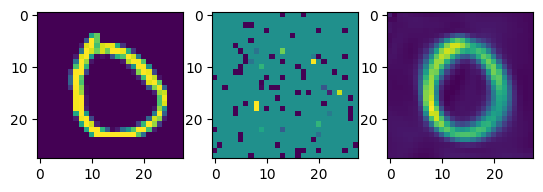

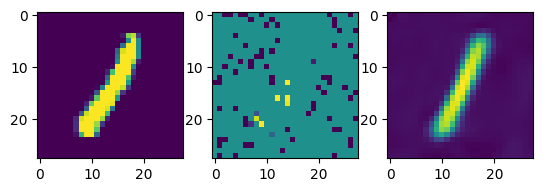

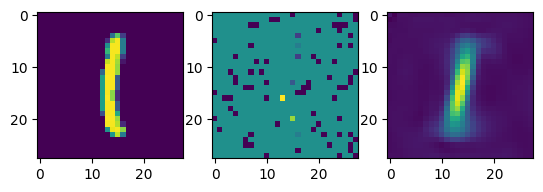

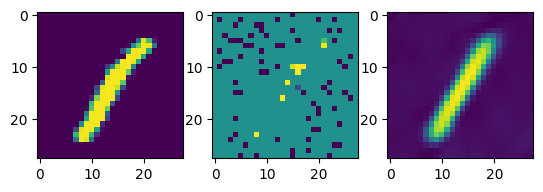

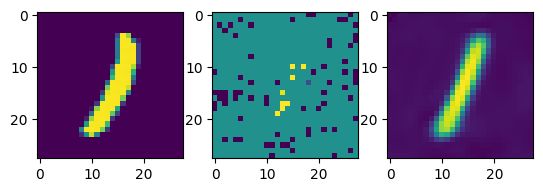

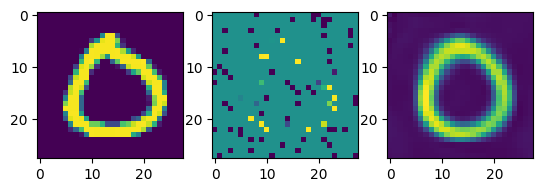

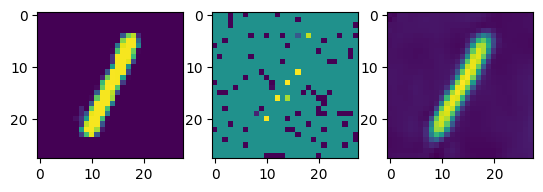

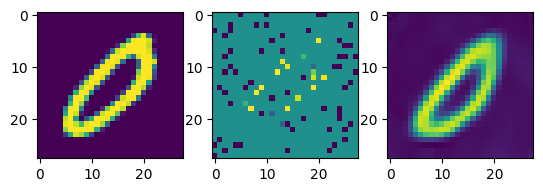

In [20]:
k = 2
m = 0
for images,labels in train_loader:
  if (k==2 or k<10):
    fig,ax = plt.subplots(1,3)
    ax[0].imshow(images[m].view(28,28))
    flattened_images = images.flatten()
    num_elements_to_mask = int((flattened_images.size()[0] * 0.9))
    masked_indices = np.random.choice(flattened_images.size()[0], num_elements_to_mask, replace = False)

    # Create a deep copy of the tensor to avoid modifying the original images
    masked_images = images.clone()
    masked_images = masked_images.view(-1)

    # Set the masked indices to zero
    masked_images[masked_indices] = 0

    # Reshape the masked tensor to its original shape
    masked_images = masked_images.view(images.shape)
    ax[1].imshow(masked_images[m].view(28,28))
    masked_images_reshaped = masked_images[m].unsqueeze(1)
    pred_image = hyper_model(masked_images_reshaped.to(device))
    random_array = pred_image[0]
    offset = 0
    for key, val in new_dict.items():
        new_dict[key] = random_array[offset:offset+val.numel()].reshape(val.shape)
        offset += val.numel()
    pred_image_new = siren_network(coordinates(28).to(device), new_dict).reshape(1,28,28)
    ax[2].imshow(pred_image_new.view(28,28).detach().cpu())
    k += 1

